In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [156]:
# Lets initially load the data (Kaggle dataset containing different tweets and their sentiment)
tweets_df = pd.read_csv('data/Tweets.csv')
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


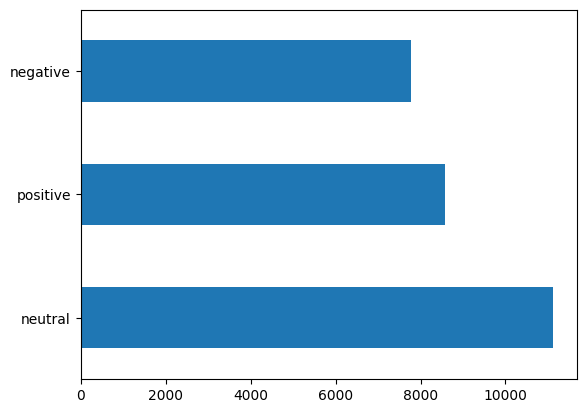

In [157]:
# We have a slightly imbalanced dataset which should be taken into account when evaluating the model/ when we try to split the data into train/test
tweets_df["sentiment"].value_counts().plot.barh()
plt.show()

# 🤗 Transformers

## Create our Dataset

In [158]:
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig
from datasets import load_dataset, Dataset, DatasetDict

In [159]:
tweets_ds = load_dataset("csv", data_dir="data/")

Found cached dataset csv (/Users/davidbreinl/.cache/huggingface/datasets/csv/default-8bed6ed4f37d7f15/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [160]:
tweets_ds.set_format("pandas")

In [161]:
tweets_df = tweets_ds["train"][:]

In [162]:
tweets_df.drop_duplicates("textID")
tweets_df = tweets_df.dropna()
tweets_df = tweets_df.reset_index()[["text", "sentiment"]] # as I am only interested in the text, and label here
tweets_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [163]:
# Lets encode the sentiment into a numeric representation
class_names = list(tweets_df["sentiment"].unique())
print(class_names)

tweets_df["sentiment"] = [class_names.index(sentiment) for sentiment in tweets_df.sentiment]
tweets_df.head()

['neutral', 'negative', 'positive']


,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


In [164]:
tweets_ds = Dataset.from_pandas(tweets_df)
tweets_ds

Dataset({
    features: ['text', 'sentiment'],
    num_rows: 27480
})

In [165]:
train_testvalid = tweets_ds.train_test_split(test_size=0.2, seed=42)

test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

train_testvalid, test_valid

(DatasetDict({
     train: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 21984
     })
     test: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 5496
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 2748
     })
     test: Dataset({
         features: ['text', 'sentiment'],
         num_rows: 2748
     })
 }))

In [166]:
tweets_ds = DatasetDict({
    'train':train_testvalid["train"],
    'test': test_valid["train"],
    'val': test_valid["test"]
})

tweets_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 2748
    })
    val: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 2748
    })
})

## Lets Encode the Text

In [167]:
model_checkpoint = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer("this is a test in order to see if the encoder is working")

{'input_ids': [101, 2023, 2003, 1037, 3231, 1999, 2344, 2000, 2156, 2065, 1996, 4372, 16044, 2099, 2003, 2551, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [168]:
# We first have to define a function that we can then apply onto our entire huggingface dataset
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Lets check if the function is actually working
tokenize_batch(tweets_ds["train"][:2]).keys()

dict_keys(['input_ids', 'attention_mask'])

In [170]:
tweets_encoded = tweets_ds.map(tokenize_batch, batched=True)
tweets_encoded["train"] # as we can see we now included the input ids and the attention mask

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'sentiment', 'input_ids', 'attention_mask'],
    num_rows: 21984
})